# Week 1 - Function 8 ((15DP, 8D))

# Setup
Let's load all the imports in the top to avoid repeating and simplify the readability of each solution.

In [32]:
import numpy as np

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel, WhiteKernel
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import norm

import matplotlib.pyplot as plt
from IPython.display import clear_output

from utils.plotting_utils import (
    plot_8D_shap_analysis,
    plot_output_outliers,
    plot_2D_mean_uncertainty
)

# Plan
Recap we have the following data: ((15, 4)) - 15DP & 4D, that can be found `./data/initial_data/function_4/`.

0. Setup:
    1. Load the data
    2. Analyse raw data - visualise data and see patterns
    3. Normalise input & output - this will make it easier to work with the data
    4. Analyse normalise data - verify (visually should look the same)
    5. Output outliers
    6. Early results
1. Build probabilistic Model
2. Acquisition Function


# 0.1. Setup > Load the data

In [33]:
X_train_raw = np.load(r"./data/initial_data/function_8/initial_inputs.npy")
y_train_raw = np.load(r"./data/initial_data/function_8/initial_outputs.npy")

# 0.2. Setup > Analyse raw data

/opt/anaconda3/lib/python3.13/site-packages/shap/plots/_beeswarm.py:1150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


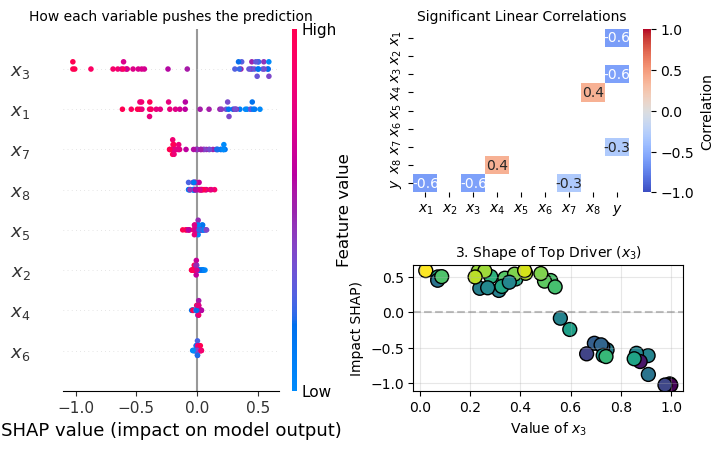

In [34]:
plot_8D_shap_analysis(X_train_raw, y_train_raw)

# 0.3. Setup > Normalise the data

In [35]:
# Normalise the data so is easier to visualise + plus needed for BO
# =================================================================
scaler_X = MinMaxScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train_raw)
y_train = scaler_y.fit_transform(y_train_raw.reshape(-1, 1)).ravel()

# 0.4. Setup > Analyse normalise data

/opt/anaconda3/lib/python3.13/site-packages/shap/plots/_beeswarm.py:1150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


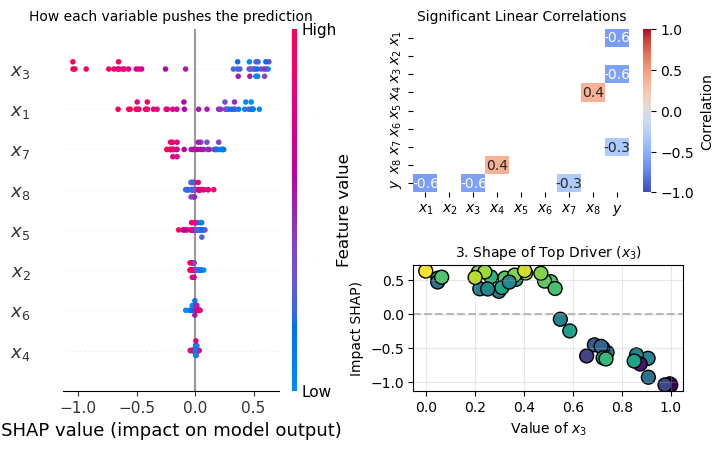

In [36]:
plot_8D_shap_analysis(X_train, y_train)

# 0.5. Setup > Output outliers

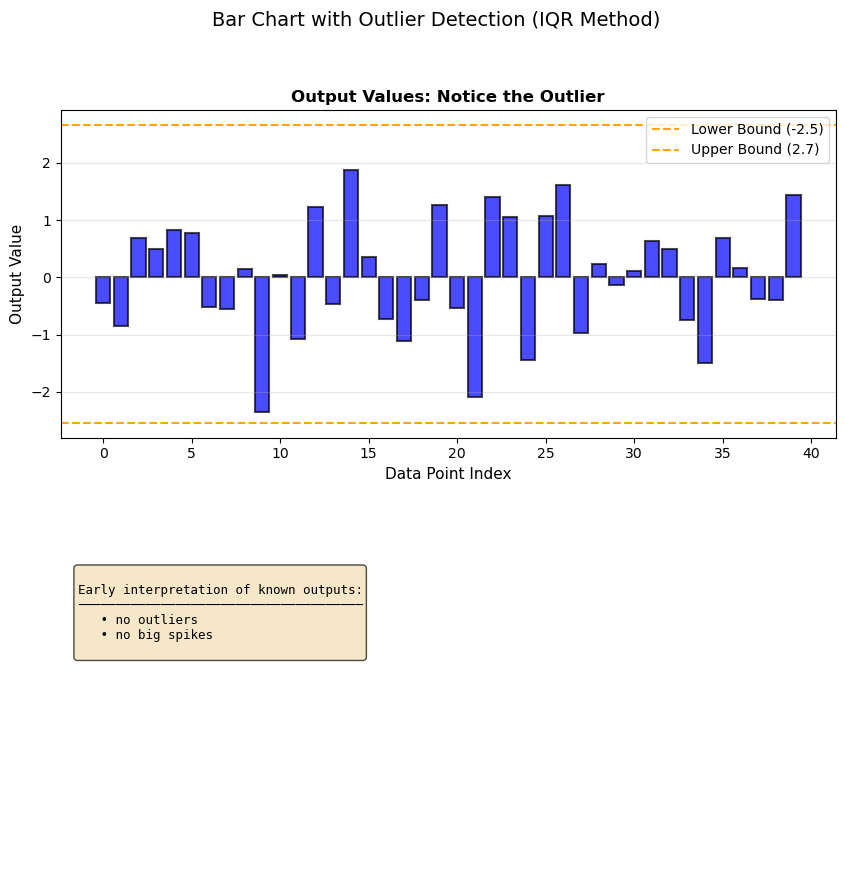

In [37]:
plot_output_outliers(X_train, y_train, "Bar Chart with Outlier Detection (IQR Method)", f"""
Early interpretation of known outputs:
──────────────────────────────────────
   • no outliers
   • no big spikes
""")

# 0.6. Setup > Early data points & outputs analyze

- $x_1$, $x_3$ has the strongest correlation with output
- no outliers
- no big spikes



# 1. Build probabilistic Model

From early exploration we know that:
- 3 outliers
- 1 quite spiky
- $x_4$ looks like the highest correlation

## Kernel choice
- Matern 5/2 since it looks like a smoth function according to the available data we know

In [38]:
kernel = (
    ConstantKernel(1.0) * Matern(
        length_scale=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
        length_scale_bounds=(1e-15, 1e15),
        nu=2.5
    ) + 
    WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-15, 1.0))
)

model = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=10,
    normalize_y=True
)

model.fit(X_train, y_train)
print(f"Optimized Kernel: {model.kernel_}")

learned_scales = model.kernel_.k1.k2.length_scale
print(f"Learned Length Scales: {learned_scales}")

n_grid = 5
x1_range = np.linspace(max(0, X_train[:, 0].min() - 0.5), min(0.999999, X_train[:, 0].max() + 0.5), n_grid)
x2_range = np.linspace(max(0, X_train[:, 1].min() - 0.5), min(0.999999, X_train[:, 1].max() + 0.5), n_grid)
x3_range = np.linspace(max(0, X_train[:, 2].min() - 0.5), min(0.999999, X_train[:, 2].max() + 0.5), n_grid)
x4_range = np.linspace(max(0, X_train[:, 3].min() - 0.5), min(0.999999, X_train[:, 3].max() + 0.5), n_grid)
x5_range = np.linspace(max(0, X_train[:, 4].min() - 0.5), min(0.999999, X_train[:, 4].max() + 0.5), n_grid)
x6_range = np.linspace(max(0, X_train[:, 5].min() - 0.5), min(0.999999, X_train[:, 5].max() + 0.5), n_grid)
x7_range = np.linspace(max(0, X_train[:, 6].min() - 0.5), min(0.999999, X_train[:, 6].max() + 0.5), n_grid)
x8_range = np.linspace(max(0, X_train[:, 7].min() - 0.5), min(0.999999, X_train[:, 7].max() + 0.5), n_grid)

X1_test, X2_test, X3_test, X4_test, X5_test, X6_test, X7_test, X8_test = np.meshgrid(
    x1_range,
    x2_range,
    x3_range,
    x4_range,
    x5_range,
    x6_range,
    x7_range,
    x8_range
)

X_grid = np.c_[X1_test.ravel(), X2_test.ravel(), X3_test.ravel(), X4_test.ravel(), X5_test.ravel(), X6_test.ravel(), X7_test.ravel(), X8_test.ravel()]

mu, sigma = model.predict(X_grid, return_std=True)


Optimized Kernel: 4.17**2 * Matern(length_scale=[2.41, 4.46, 2.26, 4.11, 18.9, 5.55e+11, 3.28, 2.06e+09], nu=2.5) + WhiteKernel(noise_level=1.39e-11)
Learned Length Scales: [2.41176837e+00 4.46073550e+00 2.25554879e+00 4.10920139e+00
 1.89150443e+01 5.55469635e+11 3.27761438e+00 2.06476140e+09]


# 2. Acquisition function

From early exploration we know that:
- $x_1$, $x_3$ has the strongest correlation with output
- no outliers
- no big spikes

So I think Expected Improvement (EI), since we don't have any single peak to exploit so we should explore.

In [39]:
def expected_improvement(mu, sigma, y_best, xi=0.1):
    """
    Expected Improvement acquisition function

    EI = E[max(f(x) - f(x_best), 0)]
    
    Parameters:
        mu: Mean predictions from GP
        sigma: Standard deviation from GP
        y_best: Current best observed value (in normalized space)
        xi: Exploration parameter (higher = more exploration)
        
    Returns:
        ei: Expected improvement values
    """
    with np.errstate(divide='warn'):
        improvement = mu - y_best - xi
        Z = improvement / sigma
        ei = improvement * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0
    return ei

y_best_norm = np.max(y_train)

xi = 0.1

ei_values = expected_improvement(mu, sigma, y_best_norm, xi=xi)

print(f"\nExpected Improvement (EI):")
print(f"  Min: {ei_values.min():.8f}")
print(f"  Max: {ei_values.max():.8f}")
print(f"  Mean: {ei_values.mean():.8f}")

print("\nSTEP 7: Finding best next point to evaluate...")

best_idx = np.argmax(ei_values)
x_next_norm = X_grid[best_idx]
ei_best = ei_values[best_idx]

# Convert to original space
x_next_orig = scaler_X.inverse_transform([x_next_norm])[0]

print(f"\n{'='*80}")
print(f"RECOMMENDED NEXT POINT")
print(f"{'='*80}")
print(f"\nIn original space:")
print(f"  Input 1: {x_next_orig[0]:.6f}")
print(f"  Input 2: {x_next_orig[1]:.6f}")
print(f"  Input 3: {x_next_orig[2]:.6f}")
print(f"  Input 4: {x_next_orig[3]:.6f}")
print(f"  Input 5: {x_next_orig[4]:.6f}")
print(f"  Input 6: {x_next_orig[5]:.6f}")
print(f"  Input 7: {x_next_orig[6]:.6f}")
print(f"  Input 8: {x_next_orig[7]:.6f}")
print(f"\nIn normalized space:")
print(f"  Input 1: {x_next_norm[0]:.6f}")
print(f"  Input 2: {x_next_norm[1]:.6f}")
print(f"  Input 3: {x_next_norm[2]:.6f}")
print(f"  Input 4: {x_next_norm[3]:.6f}")
print(f"  Input 5: {x_next_norm[4]:.6f}")
print(f"  Input 6: {x_next_norm[5]:.6f}")
print(f"  Input 7: {x_next_norm[6]:.6f}")
print(f"  Input 8: {x_next_norm[7]:.6f}")

# Get prediction at this point
y_pred_next, y_std_next = model.predict([x_next_norm], return_std=True)
y_pred_next_orig = scaler_y.inverse_transform([[y_pred_next[0]]])[0, 0]

print(f"\nPredicted output at this point:")
print(f"  Normalized: {y_pred_next[0]:.6f} ± {y_std_next[0]:.6f}")
print(f"  Original: {y_pred_next_orig:.6f}")
print(f"  95% CI: [{y_pred_next_orig - 1.96*y_std_next[0]:.6f}, {y_pred_next_orig + 1.96*y_std_next[0]:.6f}]")

print(f"\nExpected Improvement at this point: {ei_best:.8f}")


Expected Improvement (EI):
  Min: 0.00000000
  Max: 0.38198915
  Mean: 0.00342884

STEP 7: Finding best next point to evaluate...

RECOMMENDED NEXT POINT

In original space:
  Input 1: 0.009077
  Input 2: 0.246059
  Input 3: 0.022929
  Input 4: 0.009043
  Input 5: 0.986901
  Input 6: 0.022113
  Input 7: 0.035909
  Input 8: 0.041956

In normalized space:
  Input 1: 0.000000
  Input 2: 0.250000
  Input 3: 0.000000
  Input 4: 0.000000
  Input 5: 0.999999
  Input 6: 0.000000
  Input 7: 0.000000
  Input 8: 0.000000

Predicted output at this point:
  Normalized: 2.352182 ± 0.284319
  Original: 10.042564
  95% CI: [9.485300, 10.599829]

Expected Improvement at this point: 0.38198915
